## MNIST handwritten dataset

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

In [2]:
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': u'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

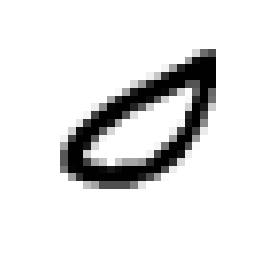

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[1234]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [6]:
y[1234]

0.0

In [7]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [8]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

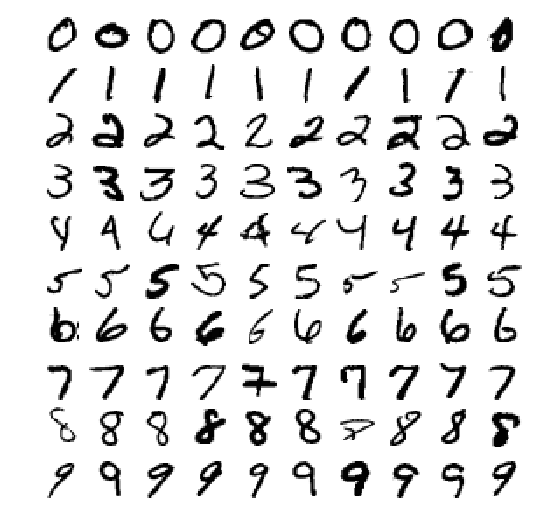

In [9]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
plt.show()

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [11]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Binary Classification (if or not digit is 5)

In [12]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [16]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [17]:
sgd_clf.predict([X[36000]])

array([ True], dtype=bool)

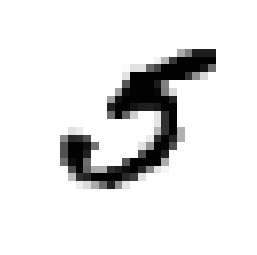

In [18]:
plot_digit(X[36000])

### implement cross valiadtion

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print (n_correct / len(y_pred))

0.9564
0.9663
0.9574


In [20]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.95385,  0.93145,  0.9506 ])

### confusion matrix

In [21]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [22]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53128,  1451],
       [ 1090,  4331]])

### evaluation matrics

- precision
- recall
- F1 score

In [23]:
# precision
from sklearn.metrics import precision_score
precision_score(y_train_5, y_train_pred)

0.74904877205119336

In [25]:
# precision TP/(TP+FP)
print (4331.0/(4331+1451))

0.749048772051


In [26]:
# recall
from sklearn.metrics import recall_score
recall_score(y_train_5, y_train_pred)

0.79893008669987087

In [27]:
# recall TP/(TP+FN)
print (4331.0/(4331+1090))

0.7989300867


In [28]:
# F1 score 2*precision*recall / (precision+recall)
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.77318575381594223

### Descision function (decision threshold)

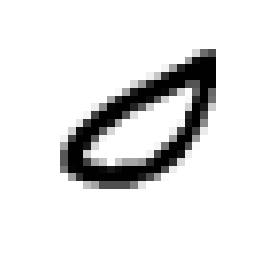

In [29]:
plot_digit(some_digit)

In [30]:
y_scores = sgd_clf.decision_function([some_digit])

In [31]:
y_scores

array([-168500.72765508])

In [36]:
from sklearn.model_selection import cross_val_predict

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [37]:
y_scores.shape

(60000, 2)

Note: there is an issue introduced in Scikit-Learn 0.19.0 where the result of cross_val_predict() is incorrect in the binary classification case when using method="decision_function", as in the code above. The resulting array has an extra first dimension full of 0s. We need to add this small hack for now to work around this issue:

In [39]:
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]

## Precision/Recall tradeoff

In [40]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

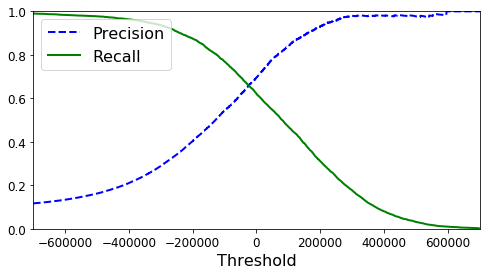

In [43]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()

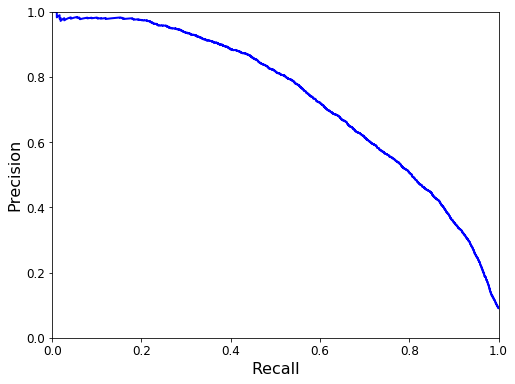

In [44]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

## ROC curve

In [45]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

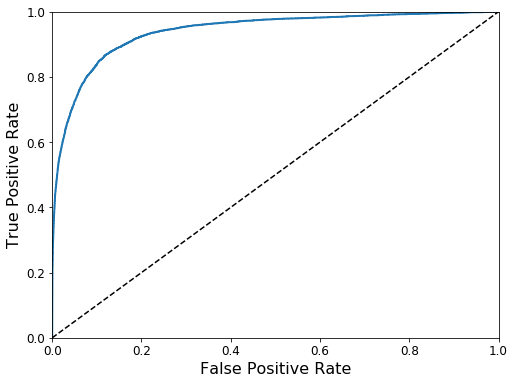

In [46]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [47]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier()
y_proba_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [49]:
y_scores_forest = y_proba_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

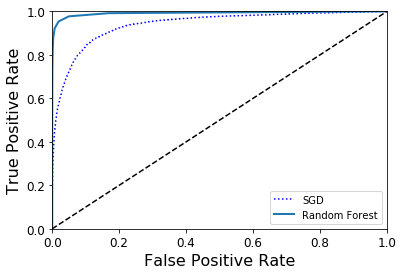

In [51]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

## Multilclass classification

In [52]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([ 0.])

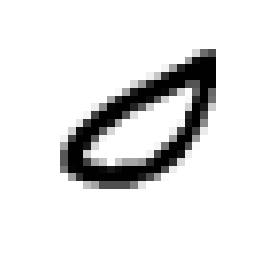

In [53]:
plot_digit(some_digit)

Scikit-Learn actually trained 10 binary classifiers, got their decision scores for the
image, and selected the class with the highest score.

In [54]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ 200811.1158143 , -805725.9678563 , -408445.63033164,
        -212935.5255587 ,  -48737.35627964, -122180.46373838,
        -585343.38299248, -439917.83577735, -767096.84905719,
        -772375.38627781]])

In [55]:
np.argmax(some_digit_scores)

0

In [56]:
sgd_clf.classes_

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [57]:
sgd_clf.classes_[0]

0.0

In [58]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([ 0.])

In [59]:
len(ovo_clf.estimators_)

45

In [60]:
forest_clf.fit(X_train, y_train)
forest_clf.predict_proba([some_digit])

array([[ 0.9,  0. ,  0. ,  0. ,  0. ,  0.1,  0. ,  0. ,  0. ,  0. ]])

In [61]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.87862428,  0.86299315,  0.83477522])

In [62]:
cross_val_score(forest_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.94056189,  0.93959698,  0.9419913 ])

In [63]:
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()
X_train_scaled = scalar.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([ 0.91091782,  0.90839542,  0.90838626])

## Error Analysis

In [64]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5736,    3,   22,   10,   10,   40,   50,   10,   38,    4],
       [   2, 6476,   44,   25,    6,   46,    6,   11,  117,    9],
       [  54,   38, 5338,   88,   87,   27,   91,   60,  158,   17],
       [  55,   39,  133, 5331,    4,  240,   35,   57,  139,   98],
       [  19,   26,   31,   10, 5376,   10,   59,   33,   78,  200],
       [  77,   48,   28,  187,   78, 4593,  115,   29,  178,   88],
       [  35,   28,   41,    1,   45,   96, 5617,    8,   46,    1],
       [  23,   21,   72,   36,   54,   10,    6, 5788,   15,  240],
       [  59,  155,   70,  153,   14,  174,   56,   27, 5003,  140],
       [  41,   33,   28,   82,  165,   33,    2,  226,   85, 5254]])

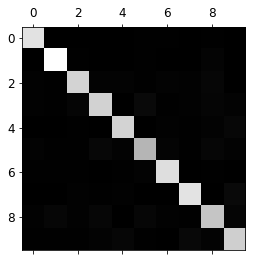

In [65]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [66]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

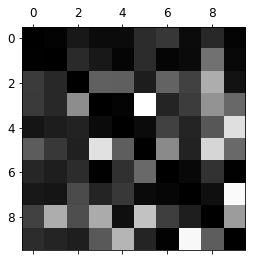

In [67]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

## Exercises

1. build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, n_jobs=4, cv=5, verbose=3)
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] n_neighbors=3, weights=uniform ..................................
[CV] n_neighbors=3, weights=uniform ..................................
[CV] n_neighbors=3, weights=uniform ..................................
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ......... n_neighbors=3, weights=uniform, score=0.941510 -11.9min
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ......... n_neighbors=3, weights=uniform, score=0.947904 -11.9min
[CV] n_neighbors=3, weights=distance .................................
[CV] ......... n_neighbors=3, weights=uniform, score=0.945750 -11.9min
[CV] ......... n_neighbors=3, weights=uniform, score=0.945273 -11.9min
[CV] n_neighbors=3, weights=distance .................................
[CV] n_neighbors=3, weights=distance .................................
[CV] ......... n_neighbors=3, weights=uniform, score=0.947399 -11.8min
[CV] n_neighbors=

In [ ]:
grid_search.best_params_

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)